In [1]:
using PyPlot,JLD2,Statistics,PyCall
# rc("font",family="serif")
# include("CGS.jl")

In [2]:
matplotlib.animation = pyimport("matplotlib.animation")

PyObject <module 'matplotlib.animation' from '/Users/bethleelindor/.julia/conda/3/lib/python3.7/site-packages/matplotlib/animation.py'>

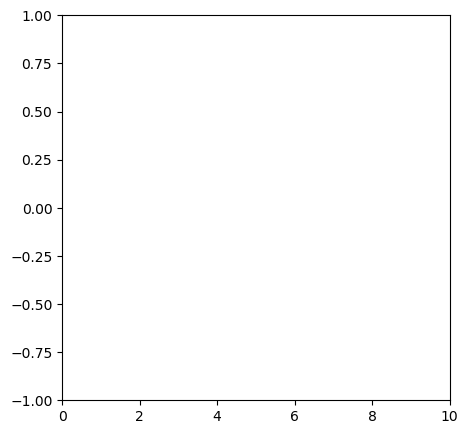

PyObject <matplotlib.animation.FuncAnimation object at 0x13dad2470>

In [3]:
function simData()
    t_max = 10.0
    dt = 0.05
    x = 0.0
    t = -dt

    function it()
        while t < t_max
            x = sin(pi * t)
            t = t + dt
            produce(x, t)
        end
    end

    Task(it)
end

function simPoints()
    task = simData()

    function points(frame_number)
        x, t = consume(task)
        line.set_data(t, x)
        return(line, "")
    end

    points
end

fig = figure(figsize=(5,5))
axis = fig.add_subplot(111)
line = axis.plot([], [], "bo", ms = 10)[1]
axis.set_ylim(-1, 1)
axis.set_xlim(0, 10)

ani = matplotlib.animation.FuncAnimation(fig, simPoints(), blit=false, interval=10, frames=200, repeat=false)

In [5]:
ani.save("test1.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
    
# # Function for creating an embedded video given a filename
# function html_video(filename)
#     open(filename) do f
#         base64_video = base64encode(f)
#         """<video controls src="data:video/x-m4v;base64,$base64_video">"""
#     end
# end

Traceback (most recent call last):
  File "/Users/bethleelindor/.julia/conda/3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/Users/bethleelindor/.julia/conda/3/lib/python3.7/site-packages/matplotlib/animation.py", line 999, in _start
    self._init_draw()
  File "/Users/bethleelindor/.julia/conda/3/lib/python3.7/site-packages/matplotlib/animation.py", line 1740, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/Users/bethleelindor/.julia/conda/3/lib/python3.7/site-packages/matplotlib/animation.py", line 1762, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
RuntimeError: <PyCall.jlwrap (in a Julia function called from Python)
JULIA: UndefVarError: consume not defined
Stacktrace:
 [1] (::var"#points#4"{Task})(::Int64) at ./In[3]:22
 [2] #invokelatest#1(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::typeof(Base.invokelatest), ::Any, ::Any, ::Var

PyCall.PyError: [91mPyError ($(Expr(:escape, :(ccall(#= /Users/bethleelindor/.julia/packages/PyCall/3fwVL/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>[39m
[91mValueError('outfile must be *.htm or *.html')[39m
[91m  File "/Users/bethleelindor/.julia/conda/3/lib/python3.7/site-packages/matplotlib/animation.py", line 1166, in save[39m
[91m    with writer.saving(self._fig, filename, dpi):[39m
[91m  File "/Users/bethleelindor/.julia/conda/3/lib/python3.7/contextlib.py", line 112, in __enter__[39m
[91m    return next(self.gen)[39m
[91m  File "/Users/bethleelindor/.julia/conda/3/lib/python3.7/site-packages/matplotlib/animation.py", line 228, in saving[39m
[91m    self.setup(fig, outfile, dpi, *args, **kwargs)[39m
[91m  File "/Users/bethleelindor/.julia/conda/3/lib/python3.7/site-packages/matplotlib/animation.py", line 857, in setup[39m
[91m    raise ValueError("outfile must be *.htm or *.html")[39m


### Simulate obs

In [1]:
include("sim_times.jl")
jd1=2.4332825e6
tref=2430000
# @time sim_times(jd1, 30, 30, true)

Finished CALCEPH computation.
  9.781270 seconds (11.72 M allocations: 575.205 MiB, 5.33% gc time)


([2.433503764417094e6, 2.4337284657592718e6, 2.43395316865273e6, 2.4341778674054984e6, 2.43440256663597e6, 2.434627271414636e6, 2.434851972427262e6, 2.435076671829833e6, 2.435301369837278e6, 2.435526069859001e6  …  2.44226709463965e6, 2.4424917958661434e6, 2.44271649902462e6, 2.4429411977330735e6, 2.443165896891193e6, 2.443390601144851e6, 2.4436153023542636e6, 2.4438400018644733e6, 2.444064699926228e6, 2.4442893998029977e6], [2.4336244053663155e6, 2.433989659466925e6, 2.434354916550314e6, 2.434720170357399e6, 2.4350854292193605e6, 2.4354506863933094e6, 2.4358159384629615e6, 2.4361811952688014e6, 2.4365464521077164e6, 2.436911708642025e6  …  2.4412947895887177e6, 2.441660044353812e6, 2.4420253033147254e6, 2.4423905602819226e6, 2.4427558136603665e6, 2.4431210708349054e6, 2.443486324911605e6, 2.443851582692736e6, 2.444216840267275e6, 2.44458209223637e6], [0.22607070756254913, 0.8936832885768102, 0.3875851066549205], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0

## Fit 2 planets

In [22]:
include("fit_planet2.jl")
@time fit_planet2(jd1,30,30,2430000,1e-5,true)

Loading.... INPUTS/tt_30sEMB30yrs.txt
Initial parameters: [3.0e-6, 224.70077409575646, 3503.7654852567784, 0.01, 0.01, 3.0e-6, 365.25642665702384, 3624.4026384093218, 0.01, 0.01]
Initial chi-square: 812.3590569057454
New initial 2-planet fit: [2.9380153697129402e-6, 224.70077831626037, 3503.765429099878, 0.03081019305418419, 0.011457500858907978, 3.2595689949612584e-6, 365.25643295059126, 3624.402560434307, 0.038440262285722275, 0.010409974573520126]
Finished 2-planet fit: [2.9380153697129402e-6, 224.70077831626037, 3503.765429099878, 0.03081019305418419, 0.011457500858907978, 3.2595689949612584e-6, 365.25643295059126, 3624.402560434307, 0.038440262285722275, 0.010409974573520126] 2
New 2-planet chi-square: 582.8973442491646
  0.925496 seconds (1.24 M allocations: 64.694 MiB)


In [23]:
@time fit_planet2(jd1,30,30,2430000,1e-5,false)

Loading.... INPUTS/tt_30snoEMB30yrs.txt
Initial parameters: [3.0e-6, 224.70077409705425, 3503.768807440609, 0.01, 0.01, 3.0e-6, 365.25642931515705, 3624.4078769599423, 0.01, 0.01]
Initial chi-square: 1116.9958037616166
New initial 2-planet fit: [3.692278422763092e-6, 224.7007779333105, 3503.7687611729925, -0.09146264187762092, -0.051138878438349133, 2.572425291589571e-6, 365.25643886693337, 3624.407756798661, -0.055422768111622764, -0.03932115153591312]
Finished 2-planet fit: [3.692278422763092e-6, 224.7007779333105, 3503.7687611729925, -0.09146264187762092, -0.051138878438349133, 2.572425291589571e-6, 365.25643886693337, 3624.407756798661, -0.055422768111622764, -0.03932115153591312] 2
New 2-planet chi-square: 646.8498193209612
  0.055315 seconds (8.27 k allocations: 1.975 MiB)


linear regression of times for each planet as a function of epochs, so find multiples ?

## Fit 3 planets

In [ ]:
include("fit_planet3.jl")
@time fit_planet3("INPUTS/tt_10.0sEMB30.0yrs.txt", jd1, 10, 30, 2430000, 1e-5, 11.8*365.25, 12.2*365.25, 10,36)

In [24]:
include("fit_planet3.jl")
fit_planet3(jd1,30,30,2430000,1e-5,11.8*365.25,12.2*365.25,10,36,true)

Planet 2 fit loaded.
Finished 3-planet fit w/ fixed period: [2.5636449587818454e-6, 224.70077915499394, 3503.765371309062, -8.47766135727757e-5, 0.006696765903281945, 3.04555823363696e-6, 365.2564445366548, 3624.402316415585, 0.014223771433809894, 0.007967444503650058, 0.0008153343308685443, 4309.949999999998, 398.11271966035935, 0.01782379554006557, -0.04071679533979835] in 20 iterations
Finished global 3-planet fit.
New 3-planet chi-square: 109.62309162509258
Maximum: -183.1848736509426 Param: [2.5422216286956403e-6, 224.70078014615882, 3503.76534735665, -0.0026337842281164846, 0.007070111985469569, 3.025608895705259e-6, 365.2564540131243, 3624.402170771069, 0.012059674661027565, 0.00829727159197438, 0.0007712306397113555, 4210.131993226086, 603.9755048375332, 0.016164431567252818, -0.04249204621169487]


15-element Array{Float64,1}:
    2.5422216286956403e-6
  224.70078014615882     
 3503.76534735665        
   -0.0026337842281164846
    0.007070111985469569 
    3.025608895705259e-6 
  365.2564540131243      
 3624.402170771069       
    0.012059674661027565 
    0.00829727159197438  
    0.0007712306397113555
 4210.131993226086       
  603.9755048375332      
    0.016164431567252818 
   -0.04249204621169487  

In [25]:
fit_planet3(jd1,30,30,2430000,1e-5,11.8*365.25,12.2*365.25,10,36,false)

Planet 2 fit loaded.
Finished 3-planet fit w/ fixed period: [3.952659740374452e-6, 224.70077782469306, 3503.7687322283437, -0.06316276127978955, -0.056474200909316374, 2.6701857105107112e-6, 365.2564513292232, 3624.4075023619616, -0.03344929126760719, -0.043254278761422384, 0.0004374762356276606, 4309.949999999998, 1232.4406792403076, -0.0722746772637546, 0.10238680566675712] in 20 iterations
Finished global 3-planet fit.
New 3-planet chi-square: 216.95718382951577
Maximum: -209.8083009567078 Param: [3.9054143218903965e-6, 224.70078008469463, 3503.768675936336, -0.06713129085431972, -0.057465222100601364, 2.6456719043334846e-6, 365.25646164115346, 3624.40734259709, -0.03675516797288188, -0.043738317868158474, 0.00034969118061929096, 4187.244650961268, 1498.0946294769674, -0.1134873127886096, 0.12687238048733113]


15-element Array{Float64,1}:
    3.9054143218903965e-6 
  224.70078008469463      
 3503.768675936336        
   -0.06713129085431972   
   -0.057465222100601364  
    2.6456719043334846e-6 
  365.25646164115346      
 3624.40734259709         
   -0.03675516797288188   
   -0.043738317868158474  
    0.00034969118061929096
 4187.244650961268        
 1498.0946294769674       
   -0.1134873127886096    
    0.12687238048733113   

if we change the linear regression to difference b/w current and first time/period estimate, same $\chi^2$ values for Hpp and Hppp

In [31]:
include("MCMC.jl")
foutput=string("MCMC/fromEMB/p",3,"_mcmc",30,"s",30,"yrs.jld2")
p=jldopen("FITS/fromEMB/p3_fit30s30yrs.jld2","r")
@time MCMC(foutput,p[string("best_p",3)],p[string("lprob_best_p",3)],30000,50,3,p["ntrans"][1:3],p["tt0"],p["tt"],p["sigtt"],true,true)

Parameters from fit: [2.54221325224715e-6, 224.70078014619605, 3503.7653473561827, -0.0026345136279696765, 0.007069730982741328, 3.0256043008594486e-6, 365.25645401372145, 3624.4021707620127, 0.012059105014406485, 0.008297004733231224, 0.0007712456797489318, 4210.127279427517, 4814.116162382293, 0.016166728775144693, -0.04249075208242041]
Maximum log Prob from fit: -183.18487363935458
Step: 162 Walker: 33 Trial Log Prob: 586.5617613478781 Prob: 0.9790113051688513 Frac: 0.35123097859705554
Step: 226 Walker: 20 Trial Log Prob: 593.169074755785 Prob: 0.2592627558700582 Frac: 0.3546583850931677
Step: 581 Walker: 32 Trial Log Prob: 591.3243190549445 Prob: 0.13712853404534026 Frac: 0.337420777073574
Step: 939 Walker: 38 Trial Log Prob: 592.5082052528968 Prob: 0.8463547471673809 Frac: 0.3312028633516554
Number of steps: 1000 Acceptance Rate: 0.33046
Step: 1030 Walker: 34 Trial Log Prob: 564.4449645476251 Prob: 1.655028694020864e-8 Frac: 0.3086253369272237
Step: 1177 Walker: 20 Trial Log Prob:

([261.40962620366923 261.40962620366923 … 587.3133642839996 587.3133642839996; 530.0953722499949 571.5066146812817 … 578.9288290374619 578.9288290374619; … ; 465.88190073571843 465.88190073571843 … 582.4790641314206 582.4790641314206; 524.4783809614005 524.4783809614005 … 578.9911171836528 585.2210156932359], [2.624694135852547e-6 2.624694135852547e-6 … 2.5485862579306724e-6 2.5485862579306724e-6; 2.692456797303937e-6 2.6580157682935344e-6 … 2.797317394423565e-6 2.797317394423565e-6; … ; 2.5244502003874137e-6 2.5244502003874137e-6 … 2.703685061481847e-6 2.703685061481847e-6; 2.605889072635306e-6 2.605889072635306e-6 … 2.4508320231287195e-6 2.482890889534182e-6]

[224.70074486591747 224.70074486591747 … 224.7007876542615 224.7007876542615; 224.70077931269861 224.70077596943278 … 224.7007803743838 224.7007803743838; … ; 224.70079130743656 224.70079130743656 … 224.700785362572 224.700785362572; 224.7007770549155 224.7007770549155 … 224.70078305117192 224.70078456077235]

[3503.76535419980

do we still need the 'offset' to find the period of Jupiter? if we remove offset but use $t_{ref}$, better $\chi^2$ for 3 planet fit. tt03 = 4814 $\pm$ 121

In [32]:
include("print_vals.jl")
print_vals(30,30,"EMB","p3")

           Fitted posterior params from MCMC/fromEMB/p3_mcmc30s30yrs.jld2
mu_1 : 2.529038376651206e-6 ± 1.9611606412778127e-7
P_1 : 224.7007802312939 ± 4.749691282173153e-6
t01 : 3503.765347501121 ± 0.0001310590942354943
ecos1 : -0.0011858630275512192 ± 0.008104371259317247
esin1 : 0.0018912254339806687 ± 0.007463733515632816
mu_2 : 3.026813971598201e-6 ± 1.3530417968053067e-7
P_2 : 365.2564540115299 ± 1.0887394869286367e-5
t02 : 3624.4021725517796 ± 0.00018454567452965817
ecos2 : 0.013126057376832518 ± 0.006445751275915976
esin2 : 0.0038994678940335805 ± 0.005984511798947203
mu_3 : 0.0007113520401687964 ± 0.00014890925510291573
P_3 : 4206.631320943575 ± 59.530644269238906
t03 : 4884.7532284952 ± 120.79225586427994
ecos3 : -0.003099120867400717 ± 0.03284892967328922
esin3 : -0.036708557253105935 ± 0.020765166885683257
esin3 : 9.417772829139751e-8 ± 3.9369347649825103e-8
Derived Parameters
mu_1 * M_star: 0.8419629419987807 ± 0.06529061000050662
ecc : 0.008854518442091562 ± 0.00692593731

### Fit 3 planets with moon

In [7]:
include("fit_moon.jl")
@time fit_moon("INPUTS/tt_30.0sEMB30.0yrs.txt", jd1, 30, 30, 2430000, 1e-5, 11*365.25, 12*365.25, 10,2,2.2,2.4,10)

Initial parameters: [3.0e-6, 224.70077409575646, 3503.7654852567784, 0.01, 0.01, 3.0e-6, 365.25642665702384, 3624.4026384093218, 0.01, 0.01]
Initial chi-square: 812.3590569057454
Finished 2-planet fit in 2 iterations.
New 2-planet chi-square: 582.8973442491646
Param: [2.9380153697129402e-6, 224.70077831626037, 3503.765429099878, 0.03081019305418419, 0.011457500858907978, 3.2595689949612584e-6, 365.25643295059126, 3624.402560434307, 0.038440262285722275, 0.010409974573520126]
Period: 4017.7500000000005 log Prob: -189.46601221816414 Param: [2.5291201524506193e-6, 224.700781748719, 3503.765315553172, -0.007524154721604066, 0.010310348089924117, 2.9904249311384083e-6, 365.2564682064298, 3624.401973096343, 0.007758608735543599, 0.010430703981311303, 0.0006103586520948597, 4017.7500000000005, 972.8355592397501, -0.002904010437680954, -0.05281346533802197]
Period: 4056.781702757627 log Prob: -187.20238046950385 Param: [2.5281086994377596e-6, 224.70078146708605, 3503.765320065127, -0.006599849

([2.54221325224715e-6, 224.70078014619605, 3503.7653473561827, -0.0026345136279696765, 0.007069730982741328, 3.0256043008594486e-6, 365.25645401372145, 3624.4021707620127, 0.012059105014406485, 0.008297004733231224, 0.0007712456797489318, 4210.127279427517, 4814.116162382293, 0.016166728775144693, -0.04249075208242041], [2.459137568961616e-6, 224.7007799684284, 3503.765353483366, -0.001514266148458868, 0.0022424477277027846, 3.030440781073223e-6, 365.2564531616774, 3624.4021832537937, 0.013008255820559226, 0.00446238274600374, 0.0007827285087471828, 4218.096902213769, 4855.056186383757, 0.01491875009236496, -0.036196969357057865, -0.00010047923994553857, 0.00015525262477382573, 2.235196526904218])

In [27]:
include("fit_moon.jl")
@time fit_moon(jd1,30,30,2430000,1e-5,2.2,2.4,10,3)

Loading.... FITS/p3_fit30s30yrs.jld2
Previous model params: [3.9054143218903965e-6, 224.70078008469463, 3503.768675936336, -0.06713129085431972, -0.057465222100601364, 2.6456719043334846e-6, 365.25646164115346, 3624.40734259709, -0.03675516797288188, -0.043738317868158474, 0.00034969118061929096, 4187.244650961268, 1498.0946294769674, -0.1134873127886096, 0.12687238048733113]
Finished lunar search: [2.3844520331435646e-6, 224.70077994566037, 3503.768678133486, -0.0007783380263909741, 0.0021738287415496837, 3.0322030524457964e-6, 365.2564518574759, 3624.4074914709117, 0.013218145402848224, 0.004282806404613346, 0.00078685555354462, 4227.19195270933, 619.1203942883191, 0.01397547862577287, -0.034429446381108446, -1.5301800832127586e-5, -0.0018231262500707942, 2.311111111111111] in 20 iterations
Finished global moon fit.
Lunar chi-square: 108.28194173979914
Maximum: -182.70479748946045 Param: [2.384424432392215e-6, 224.7007799456815, 3503.768678133689, -0.0007783247539810868, 0.0021727247

18-element Array{Float64,1}:
    2.384424432392215e-6 
  224.7007799456815      
 3503.768678133689       
   -0.0007783247539810868
    0.0021727247987452162
    3.0322029402257203e-6
  365.25645185796003     
 3624.407491463483       
    0.013218159190585116 
    0.004281927757742217 
    0.0007868596724091433
 4227.186843338152       
  619.1468842361991      
    0.013975790714605026 
   -0.03442714789237476  
   -1.530082935088796e-5 
   -0.0018231379967262153
    2.3129311609831533   

## Fit 4 planets

w/o offset but with tref

In [6]:
include("fit_planet4.jl")
@time fit_planet4("INPUTS/tt_30.0sEMB30.0yrs.txt", jd1,30,30,2430000,1e-5, 11.8*365.25, 12.2*365.25,10,36, 1.8*365.25, 2.2*365.25,10)

Initial parameters: [3.0e-6, 224.70077409575646, 3503.7654852567784, 0.01, 0.01, 3.0e-6, 365.25642665702384, 3624.4026384093218, 0.01, 0.01]
Initial chi-square: 812.3590569057454
Finished 2-planet fit in 2 iterations.
New p2 chi-square: 582.8973442491646
Param: [2.9380153697129402e-6, 224.70077831626037, 3503.765429099878, 0.03081019305418419, 0.011457500858907978, 3.2595689949612584e-6, 365.25643295059126, 3624.402560434307, 0.038440262285722275, 0.010409974573520126]
Finished 3-planet fit w/ fixed period: [2.563636171884876e-6, 224.70077915501258, 3503.7653713087975, -8.54914833964373e-5, 0.006696424150244993, 3.045553603852875e-6, 365.25644453678115, 3624.4023164135374, 0.014223224576339085, 0.00796719171825563, 0.0008153454745067351, 4309.949999999998, 4708.067056722962, 0.01782479095689238, -0.04071577901832235]
Finished 3-planet fit in 2 iterations.
New 3-planet chi-square: 109.6230915523655
Maximum: -183.18487362506883 Param: [2.5422147419487485e-6, 224.70078014621996, 3503.7653

([2.5422147419487485e-6, 224.70078014621996, 3503.7653473555456, -0.0026343267467731474, 0.0070695947650385536, 3.025605235838036e-6, 365.2564540139241, 3624.4021707586385, 0.012059248621926238, 0.008296881504704779, 0.0007712387127985479, 4210.125307988029, 4814.1197361733775, 0.016165680447941387, -0.042491035438553204], [2.4797368317700974e-6, 224.70077540765067, 3503.7654450073856, -0.005918101397840288, 0.005921079577658514, 2.9781433929288205e-6, 365.2564548149991, 3624.402153775526, 0.008846312338042778, 0.008152647419863131, 3.9884859544190433e-7, 687.2013422163191, 418.7907759301823, -0.10251106228279193, -0.07880662007644161, 0.0010011496184743182, 4355.610749222095, 4622.5627530038155, 0.026287840938589428, -0.04558281041350565])

In [31]:
include("fit_planet4.jl")
fit_planet4(jd1,30,30,2430000,1e-5,1.8*365.25,2.2*365.25,10,36,true)

3503.764224029146
Planet 3 fit loaded.
Finished 3-planet fit w/ fixed period: [2.476370716360381e-6, 224.70077552673516, 3503.7654458317234, -0.005725995160143898, 0.005853446370266811, 2.979688950181277e-6, 365.256454687972, 3624.402156566885, 0.008987440656895893, 0.00808669783803928, 4.003872908491878e-7, 687.4315104491986, 416.9932423779369, -0.10308558240364257, -0.07630001429523084, 0.0009960154998875192, 4355.240453000815, 269.0019387386575, 0.026268766456938125, -0.045280984138571095] in 2 iterations
Finished global 4-planet fit.
New 4-planet chi-square: 77.38852437496628
Maximum: -169.60470172285304 Param: [2.4797327645063745e-6, 224.70077540783217, 3503.765445004103, -0.005918013520271995, 0.005920552902168205, 2.978144199188821e-6, 365.2564548155953, 3624.4021537664157, 0.008846412607389708, 0.008152238066832872, 3.9884096324315784e-7, 687.2013847033735, 418.79018585750407, -0.10251104153775775, -0.0788074510716646, 0.0010011469469405848, 4355.602495719337, 266.9770432084552

ArgumentError: [91mArgumentError: attempted to truncate a file that was already open[39m

In [7]:
include("MCMC.jl")
foutput=string("MCMC/fromEMB/p",4,"_mcmc",30,"s",30,"yrs.jld2")
p=jldopen("FITS/fromEMB/p4_fit30s30yrs.jld2","r")
@time MCMC(foutput,p[string("best_p",4)],p[string("lprob_best_p",4)],30000,50,4,p["ntrans"][1:4],p["tt0"],p["tt"],p["sigtt"],true,true)

Parameters from fit: [2.4797368317700974e-6, 224.70077540765067, 3503.7654450073856, -0.005918101397840288, 0.005921079577658514, 2.9781433929288205e-6, 365.2564548149991, 3624.402153775526, 0.008846312338042778, 0.008152647419863131, 3.9884859544190433e-7, 687.2013422163191, 418.7907759301823, -0.10251106228279193, -0.07880662007644161, 0.0010011496184743182, 4355.610749222095, 4622.5627530038155, 0.026287840938589428, -0.04558281041350565]
Maximum log Prob from fit: -169.60470168540738
Step: 7 Walker: 48 Trial Log Prob: 563.3071879728853 Prob: 0.061953249713134824 Frac: 0.3563218390804598
Step: 163 Walker: 47 Trial Log Prob: 580.7576154962776 Prob: 0.018038135388398494 Frac: 0.3398797103228182
Step: 384 Walker: 4 Trial Log Prob: 590.7474941402056 Prob: 0.7776321735239355 Frac: 0.3127284118199854
Step: 602 Walker: 15 Trial Log Prob: 594.090661156537 Prob: 0.0262643253172994 Frac: 0.30550473973058373
Number of steps: 1000 Acceptance Rate: 0.3017
Step: 1070 Walker: 21 Trial Log Prob: 59

([122.40855027326698 122.40855027326698 … 594.5095094903909 594.5095094903909; 524.4126784581706 524.4126784581706 … 590.8970144114263 590.8970144114263; … ; 14.18808146413923 309.40403370899037 … 583.2314064430307 592.1558211943548; 120.9546894224128 499.0787316041503 … 601.0819520945282 601.0819520945282], [2.4444289652124166e-6 2.4444289652124166e-6 … 2.7330366228614664e-6 2.7330366228614664e-6; 2.4702767605967316e-6 2.4702767605967316e-6 … 2.497034974630914e-6 2.497034974630914e-6; … ; 2.5926113203652046e-6 2.565971582679767e-6 … 2.307505154407945e-6 2.393627419082697e-6; 2.5626370698917757e-6 2.506684344033795e-6 … 2.388655116655588e-6 2.388655116655588e-6]

[224.70076091884061 224.70076091884061 … 224.7007699412039 224.7007699412039; 224.70077256017342 224.70077256017342 … 224.70078047649136 224.70078047649136; … ; 224.7007721744695 224.70077962055936 … 224.7007858670404 224.70078315665162; 224.70079201024205 224.70078091989726 … 224.70077782066647 224.70077782066647]

[3503.7654

In [8]:
include("print_vals.jl")
print_vals(30,30,"EMB","p4")

           Fitted posterior params from MCMC/fromEMB/p4_mcmc30s30yrs.jld2
mu_1 : 2.5495943326888427e-6 ± 1.9618978455813724e-7
P_1 : 224.7007754151153 ± 5.5047072744343135e-6
t01 : 3503.7654412237334 ± 0.00014636814224859086
ecos1 : -0.001917905276235358 ± 0.010178811507634217
esin1 : 0.009981231732200394 ± 0.008306078748314811
mu_2 : 3.0112985508216392e-6 ± 1.3768801328706098e-7
P_2 : 365.25644778620557 ± 1.0677490117258064e-5
t02 : 3624.402265744747 ± 0.0001824303939300982
ecos2 : 0.011853919814466296 ± 0.008182926443448747
esin2 : 0.010583486374144448 ± 0.006412968151929074
mu_3 : 3.6177762328917515e-7 ± 1.6100391074820135e-7
P_3 : 686.7194102536184 ± 11.551744065796456
t03 : 395.98954075580406 ± 80.35136329353709
ecos3 : -0.03809343772519043 ± 0.08669768848746003
esin3 : -0.08091519744866854 ± 0.07760469816188777
mu_4 : 0.0008818112072651301 ± 0.000229024127094097
P_4 : 4450.22142048097 ± 39.915103157397766
t04 : 1.5312176155571824 ± 0.7285947867151982
ecos4 : 0.002957621990564639 

### Fit 4 planets with moon

In [28]:
include("fit_planet4.jl")
fit_planet4(jd1,10,30,2430000,1e-5, 1.8*365.25, 2.2*365.25,10,36)

Period: 547.8749999999998 log Prob: -394.9877081343094 Param: [0.00019770881223109377, 224.700770989801, 2.4335037688869582e6, -11.760136978852739, 3.845205252205111, 6.94791540233336e-6, 365.2564286284245, 2.4336244079311285e6, 0.01625718033637096, 0.0009135515883817364, 9.461004590644902e-8, 547.8749999999998, 2.4389448928514877e6, 0.009574091433022548, 0.00963530179765613, -0.3564158112703761, -58025.91763899769, 1.7375903595603928e6, 6.166461114945513, 156.89490509222657, 0.000766870840864711, -0.0004557165361223465, 26.231301118454365]
Period: 626.2952559481723 log Prob: -231.63905133603816 Param: [1.8445972225937508e-6, 224.70077788885212, 2.433503768735981e6, -0.015958260277731614, -0.0006283719627766826, 2.9471404767537666e-6, 365.2564559324969, 2.4336244074843107e6, 0.0008226809798522476, 0.0025565992334057484, 3.9550278845224303e-7, 626.2952559481723, 2.4389398389979885e6, -0.015819061124821857, -0.035826766871111554, 0.0007143616484056519, 4151.168985640608, 2.43907840978165

([3.7289123126215386e-6, 224.70077616301975, 2.4335037687782003e6, -0.07694204392322318, -0.06265537975523863, 2.608664024845969e-6, 365.25645891552847, 2.433624407437844e6, -0.04511816215660164, -0.04818773972024614, 0.0003907609176202404, 4222.098360512293, 2.4398926368598826e6, -0.09007320902956864, 0.12030673455053578], [2.3728417355698103e-6, 224.70077643691312, 2.4335037687693886e6, 0.0031004982371343466, -0.002386815420274779, 3.064835888012818e-6, 365.2564504835976, 2.433624407565781e6, 0.015734795052767203, 0.0004608482577830722, 0.0008405817480523152, 4244.405642474456, 2.439076449650081e6, 0.020855975162163278, -0.034225760785312094, 5.279707336316315e-5, -0.0017918555433348777, 2.3135965399051712], [2.455609579286641e-6, 224.70077577726735, 2.4335037687877933e6, 0.0067424771660325716, 0.002493053690918272, 3.0888809813665807e-6, 365.25645377041604, 2.4336244075289955e6, 0.018569982045217856, 0.004757968359792486  …  0.09836471976467792, -0.123505379683503, 0.000789685918578

## Fit 5 planets

In [55]:
include("fit_planet5.jl")
@time fit_planet5("INPUTS/tt_30.0snoEMB30.0yrs.txt", jd1, 30, 30, 2430000, 1e-5, 11*365.25, 12*365.25, 10,2,1.5*365.25,4*365.25,10,1.5*365.25,3*365.25,10)

Initial parameters: [3.0e-6, 224.70077409705425, 3503.768807440609, 0.01, 0.01, 3.0e-6, 365.25642931515705, 3624.4078769599423, 0.01, 0.01]
Initial chi-square: 1116.9958037616166
Finished 2-planet fit in 2 iterations.
New p2 chi-square: 646.8498193209612
Param: [3.692278422763092e-6, 224.7007779333105, 3503.7687611729925, -0.09146264187762092, -0.051138878438349133, 2.572425291589571e-6, 365.25643886693337, 3624.407756798661, -0.055422768111622764, -0.03932115153591312]
Finished 3-planet fit w/ fixed period: [3.960916647474602e-6, 224.70077728877877, 3503.768745880229, -0.06251566587385583, -0.05617101043286336, 2.6755253082667e-6, 365.2564486463442, 3624.407544324304, -0.032895968905825815, -0.043105029558548016, 0.000457969813411406, 4340.82963794419, 1171.9662164877855, -0.06439281244417723, 0.09885860889098927]
Finished global 3-planet fit in 2 iterations.
New 3-planet chi-square: 216.9571838733844
Maximum: -209.8083009645936 Param: [3.905392403096112e-6, 224.70078008483736, 3503.7

([5.237188856431306e-6, 224.70077933695654, 3503.7686980821295, 0.004691243030813781, -0.0388096384539098, 2.9899866556326524e-6, 365.25645472185016, 3624.407476345941, 0.016333140839217317, -0.030649084314979914, 1.3759834980922222e-5, 1457.3912666480735, -47.60931630859596, -0.042004462802081456, 0.491374743201507, 0.0004546471442867087, 4272.749457844985, 826.4240188684772, -0.07988030093193335, -0.0019646419859845345], [5.237188856431306e-6, 224.70077902258524, 3503.768696250564, 0.004691243030813781, -0.0388096384539098, 2.9899866556326524e-6, 365.2564536973664, 3624.407481786325, 0.016333140839217317, -0.030649084314979914  …  0.491374743201507, 0.0004546471442867087, 4272.749457844985, 826.4240188684772, -0.07988030093193335, -0.0019646419859845345, -7.0, 0.0, 0.01, 0.01])

In [45]:
include("MCMC.jl")
foutput=string("MCMC/fromEMB/p",5,"_mcmc",30,"s",30,"yrs.jld2")
# p=jldopen("FITS/fromEMB/p5_fit30s30yrs.jld2","r")
# @time MCMC(foutput,p[string("best_p",5)],p[string("lprob_best_p",5)],30000,50,5,p["ntrans"][1:5],p["tt0"],p["tt"],p["sigtt"],true,true)

"MCMC/fromEMB/p5_mcmc30s30yrs.jld2"

In [21]:
print_vals(30,30,"EMB","p5")

MCMC file for EMB with p5 model at 30 secs and 30 yrs doesn't exist!!!!


In [2]:
include("decompose_ttvs.jl")
include("plot_likelihood.jl")
include("corner_plot.jl")
include("plot_ttvs.jl")

plot_ttvs (generic function with 2 methods)

## Posterior Distributions

### Plot masses of Venus and Earth in $M_{\oplus}$

In [ ]:
xvalue = vec(par_mcmc[:,iburn:nsteps,1]).* CGS.MSUN/CGS.MEARTH
yvalue = vec(par_mcmc[:,iburn:nsteps,6]).*CGS.MSUN/CGS.MEARTH
optx = mu_1.* CGS.MSUN/CGS.MEARTH
opty = mu_2.* CGS.MSUN/CGS.MEARTH
truex = 0.815
truey = 1
nbins = 50
corner_plot(xvalue,yvalue,nbins,optx,opty,truex,truey)
xlabel(L"Mass of Venus [$M_{\oplus}$]")
ylabel(L"Mass of Earth [$M_{\oplus}$]")
# savefig("massposteriors.png")

In [6]:
include("corner_plot.jl")
corner_hist(10.0,20.0,"EMB","p3",50)

In [5]:
corner_hist(10.0,20.0,"noEMB","p3",50)

### Plot eccentricities of Venus and Earth

In [ ]:
xvalue = sqrt.(vec(par_mcmc[:,iburn:nsteps,4]).^2 + vec(par_mcmc[:,iburn:nsteps,5]).^2)
yvalue = sqrt.(vec(par_mcmc[:,iburn:nsteps,9]).^2 + vec(par_mcmc[:,iburn:nsteps,10]).^2)
optx = sqrt(e1cosw1^2 + e1sinw1^2)
opty = sqrt(e2cosw2^2 + e2sinw2^2)
truex = 0.00677323
truey = 0.01671022
nbins=50
corner_plot(xvalue,yvalue,nbins,optx,opty,truex,truey)
xlabel("Eccentricity of Venus")
ylabel("Eccentricity of Earth")
# savefig("eccposteriors.png")

### Plot periods of Venus and Earth?

In [ ]:
xvalue = vec(par_mcmc[:,iburn:nsteps,2])
yvalue = vec(par_mcmc[:,iburn:nsteps,7]) 
optx = P_1
opty = P_2
truex = 225
truey = 365
nbins=50
corner_plot(xvalue, yvalue, nbins, optx, opty, truex, truey)
xlabel(L"Period of Venus [$days$]")
ylabel(L"Period of Earth [$days$]")


### Plot mass of Jupiter $M_{Jup}$ vs its eccentricity

In [ ]:
xvalue = vec(par_mcmc[:,iburn:nsteps,11]).* CGS.MSUN/CGS.MJUPITER
yvalue = sqrt.(vec(par_mcmc[:,iburn:nsteps,14]).^2 + vec(par_mcmc[:,iburn:nsteps,15]).^2)
optx = mu_3.* CGS.MSUN/CGS.MJUPITER
opty = sqrt(e3cosw3^2 + e3sinw3^2)
truex = 1
truey = 0.04839266
nbins=50
corner_plot(xvalue, yvalue, nbins, optx, opty, truex, truey)
xlabel(L"Mass of Jupiter [$M_{Jup}$]")
ylabel("Eccentricity of Jupiter")
# savefig("jupiterposteriors.png")

### Plot time of inferior conjuction [JD - 24550000] $t_{03}$ vs Jupiter period $P_3$. 

In [ ]:
xvalue = vec(par_mcmc[:,iburn:nsteps,12])
yvalue = vec(par_mcmc[:,iburn:nsteps,13]) .- 2.443e6
optx = P_3
opty = t03 .- 2.443e6
# truex = 1
# truey = 0.04839266
nbins=50
corner_plot(xvalue, yvalue, nbins, optx, opty, truex, truey)
xlabel(L"Period of Jupiter [$days$]")
ylabel(L"$t_{0}$ of Jupiter")

### Plot TTV of Earth due to Moon $t_{max}$ vs phase change of Moon per Earth year $\Delta \phi$

In [ ]:
# function plot_posterior(samples,bins,range)
# tmax = vec(sqrt(par_mcmc[:,iburn:nsteps,16]).^2 + vec(par_mcmc[:,iburn:nsteps,17]).^2)
xvalue = sqrt.(vec(par_mcmc[:,iburn:nsteps,16].^2) + vec(par_mcmc[:,iburn:nsteps,17].^2)).* (24 * 60)
yvalue = vec(par_mcmc[:,iburn:nsteps,18]).* 57.2957795 
optx = sqrt(param[16]^2 + param[17]^2).* (24 * 60)
opty = param[18].* 57.2957795 
# truex = 
truey = 2.3122 .* 57.2957795 
meanx=mean(xvalue);sigmax=std(xvalue)
meany=mean(yvalue);sigmay=std(yvalue)
nbins=50
corner_plot(xvalue,yvalue,nbins,optx,opty,truex,truey)
xlabel("Amplitude of Moon [min]")
ylabel("Phase Change of Moon [deg]")
# savefig("moonposteriors.png")

### Plot longitude of ascending node $\Omega$ vs longitude of pericenter $\bar \omega$; with argument of pericenter $\omega$

In [245]:
g=jldopen("FITS/fromEMB/p3_fit30.0s30.0yrs.jld2","r")
tt,tt0,sigtt,ttmodel = g["tt"],g["tt0"],g["sigtt"],g["ttmodel"]
pbest_global = g["best_p3"]
nplanet,ntrans = g["nplanet"],g["ntrans"]
# pair_ttvs = decompose_ttvs(nplanet,ntrans,pbest_global) .* (24 * 60)
n1,n2,n3 = ntrans
mu1,P1,t01,ecosw1,esinw1 = pbest_global[1:5]
mu2,P2,t02,ecosw2,esinw2 = pbest_global[6:10]
mu3,P3,t03,ecosw3,esinw3 = pbest_global[11:15]
# time1 = collect(t01 .+ range(0,stop=n1-1,length=n1) .* P1)
# time2 = collect(t02 .+ range(0,stop=n2-1,length=n2) .* P2)
tt1,tt01 = tt[1:n1],tt0[1:n1]
tt2,tt02 = tt[n1+1:n1+n2],tt0[n1+1:n1+n2]

([2.433624404896996e6, 2.433989659571913e6, 2.4343549169757506e6, 2.434720170198379e6, 2.4350854290913274e6, 2.435450686189174e6, 2.435815938772034e6, 2.436181195351934e6, 2.436546452039964e6, 2.4369117088691522e6  …  2.441294789551072e6, 2.441660044224819e6, 2.4420253037346653e6, 2.4423905602110857e6, 2.4427558136647013e6, 2.443121070883718e6, 2.4434863245670246e6, 2.4438515822939654e6, 2.4442168407435166e6, 2.4445820922158603e6], [2.433624402638408e6, 2.433989659065065e6, 2.434354915491722e6, 2.434720171918379e6, 2.435085428345036e6, 2.4354506847716933e6, 2.435815941198351e6, 2.436181197625008e6, 2.436546454051665e6, 2.436911710478322e6  …  2.4412947875982076e6, 2.4416600440248647e6, 2.4420253004515218e6, 2.442390556878179e6, 2.442755813304836e6, 2.443121069731493e6, 2.44348632615815e6, 2.4438515825848076e6, 2.4442168390114647e6, 2.444582095438122e6])

## Longitudes

In [258]:
J2000 = 2451545.0
jd1=2.4332825e6
calc_rad(value) = value * pi/180
calc_deg(value) = value * 180/pi
calc_omega(pomega,Omega) = pomega - Omega
calc_M(t,t0,P)=2pi .* (t.-t0) ./ P
calc_L(t,t0,P,esinw)=((360/P) .* (t.-t0)) .+ 2*esinw 

calc_M (generic function with 1 method)

calc_L from Agol & Deck 2015 equation 5 for mean longitude

In [163]:
function calc_L(t,t0,P,esinw)
    lambda = ((360/P) .* (t.-t0)) .+ 2*esinw
    return lambda
end

calc_L (generic function with 1 method)

In [133]:
P1/365.25,P2/365.25,P3/365.25

(0.6151971978957823, 1.000017663879583, 11.597325781312636)

In [246]:
e1 = sqrt.(ecosw1.^2 + esinw1.^2)
e2 = sqrt.(ecosw2.^2 + esinw2.^2)
e3 = sqrt.(ecosw3.^2 + esinw3.^2)
e1,e2,e3

(0.007552295476634351, 0.01466059740501133, 0.0454727262813164)

We assume an edge-on, plane-parallel system with the $\Omega = 0$ such that $\omega = \varpi$

In [247]:
w1 = calc_deg(atan(esinw1,ecosw1))
w2 = calc_deg(atan(esinw2,ecosw2))
w3 = calc_deg(atan(esinw3,ecosw3))
w1,w2,w3

(110.24093749596905, 34.5333600284138, -69.08910379986942)

$L \equiv \lambda$. Check to see if $\lambda_{E} \sim \lambda_{V}$ at their respective transit times. $\lambda mod 2 \pi = \lambda_{obs}$[what?] where $\lambda_{obs}$ is longitude that both Earth and Venus have.

In [273]:
L_1 = calc_L(tt1,t01,P1,esinw1)
L_2 = calc_L(tt2,t02,P2,esinw2)
L_1,L_2
# for i=1:length(tt2)
#     println(L_1[i]," ",L_2[i])
# end

([0.012371787476397042, 360.0133343565473, 720.0169824870229, 1080.0135526690897, 1440.0122255198048, 1800.0170057665478, 2160.0177544631683, 2520.01589496752, 2880.0098961630033, 3240.010708947574  …  14040.012713830656, 14400.014083406671, 14760.016677415953, 15120.013983489262, 15480.011012335533, 15840.016055447844, 16200.017730867143, 16560.01607892639, 16920.011100616346, 17280.00925384235], [0.0193074189826956, 360.01755401405876, 720.0184902573101, 1080.015305463873, 1440.017709387891, 1800.0183440440064, 2160.0145286887832, 2520.0146528520695, 2880.014883589056, 3240.0152534528497  …  7560.018441732332, 7920.0166871745005, 8280.01969911849, 8640.01972129125, 9000.016764160737, 9360.017518242807, 9720.014787497934, 10080.016042194638, 10440.018009102552, 10800.01309921289])

In [248]:
L_1.+w1,L_2.+w2#,L_3.+w3

([110.23441005698854, 470.2353371876402, 830.2388169261313, 1190.2355142877648, 1550.2334225068087, 1910.2392921671903, 2270.2397960284884, 2630.2377110567327, 2990.232755940259, 3350.232222648511  …  14150.234538806002, 14510.235477996555, 14870.238889408038, 15230.235784719922, 15590.233067660847, 15950.238464156784, 16310.239487117586, 16670.237586353087, 17030.233029423012, 17390.23145479437], [34.537352959732864, 394.53369807432495, 754.5375676629656, 1114.5321719224687, 1474.5349057276383, 1834.5375357509597, 2194.530177307468, 2554.5326940934497, 2914.533180203558, 3274.531020179454  …  7594.537901329611, 7954.533481497117, 8314.536540632798, 8674.53882086993, 9034.532613647943, 9394.535745181794, 9754.533393802163, 10114.532368817097, 10474.537012190096, 10834.530400168693])

Venus transit occurs 0.277 radians after it goes through periastron. Earth transit occurs -0.552 radians after it goes through periastron. 

In [105]:
calc_deg(0.277),calc_deg(-0.552)

(15.870930925123806, -31.627270291221446)

true $\lambda$ from planet body data sheet: 181.9, 100, 34 degrees ##181.97973, 100.46435, 34.40438

In [218]:
calc_L(jd1,t01,P1,esinw1),calc_L(jd1,t02,P2,esinw2)

(-354.506249963048, -336.98621027107424)

In [238]:
calc_L(J2000,t01,P1,esinw1),calc_L(J2000,t02,P2,esinw2)# L_3 = calc_L(tt3,J2000,P3,esinw3)

(28904.40466370642, 17662.69590703417)

In [263]:
(((360/P1) .* (t01 .- J2000)) .+ 181.97909950)

-28722.4353440571

In [235]:
(((360/P2) .* (t02 .- J2000)) .+ 100.46457166)

-17562.230413677655

In [209]:
28904.428615380195 -28722.4353440571, 17662.716756770507-17562.235563336195

(181.99327132309554, 100.48119343431244)

Calculate angular diffence between J2000 and time of periastron passage

In [266]:
M1,M2,M3=360*(J2000-t01)/P1 , 360*(J2000-t02)/P2 , 360*(J2000-t03)/P3

(28904.4144435571, 17662.700134996194, 1070.4307553559763)

In [37]:
true_w1 = 131.60246718 - 0.00268329*.5
true_w2 = 102.94719 - 0.32327364*.5
# true_w3 = 14.72847983 - 0.21252668*.5
true_w1,true_w2#,true_w3

(131.601125535, 102.78555318000001)

## Lunar phase offset

Calculate lunar phase offset, $\Delta\phi= (P_p/P_s - round(P_p/P_s))*2\pi$ 

In [191]:
calc_dphi(P_p,P_s) = (P_p/P_s - round(P_p/P_s))*2pi

calc_dphi (generic function with 1 method)

In [192]:
dphi=calc_dphi(365.256355,27.322)
println(dphi," rad or ",calc_deg(dphi)," degrees")

2.315859255328402 rad or 132.68896127662714 degrees


To calculate moon amplitude, use $t_{max} = \frac{M_s a_s P_p}{(M_s + M_p) 2\pi a_p}$ based on velocity of EMB about Sun

## Saturn Search

how large is Saturn signal on Earth? less than 10 seconds

In [2]:
if !@isdefined(TTVFaster)
    include("TTVFaster/src/TTVFaster.jl")
  using Main.TTVFaster
end
import Main.TTVFaster.ttv_wrapper
import Main.TTVFaster.chisquare

In [5]:
per1=365.25;per2=29.55*365.25
t01=2.433503765751229e6;t02=2.433624402577811e6
init_param = [3.0444959103088e-6,per1,t01,0.01,0.01,
            0.0002853553687428353,per2,t02,0.01,0.01] 
println("Initial parameters: ",init_param)
# Set up data structure to hold planet properties,passed to TTVFaster
nt1=29; nt2=2
jmax = 5
data=init_param
p1=TTVFaster.Planet_plane_hk(data[1],data[2],data[3],data[4],data[ 5])
p2=TTVFaster.Planet_plane_hk(data[6],data[7],data[8],data[9],data[10])
time1 = collect(p1.trans0 .+ range(0,stop=nt1-1,length=nt1) .* p1.period)
time2 = collect(p2.trans0 .+ range(0,stop=nt2-1,length=nt2) .* p2.period)
# Initialize the computation of the Laplace coefficients:
ttv1 = zeros(nt1)
ttv2 = zeros(nt2)
# Need first call to TTVFaster,without optimizing
dummy=TTVFaster.compute_ttv!(jmax,p1,p2,time1,time2,ttv1,ttv2)

Initial parameters: [3.0444959103088e-6, 365.25, 2.433503765751229e6, 0.01, 0.01, 0.0002853553687428353, 10793.1375, 2.433624402577811e6, 0.01, 0.01]


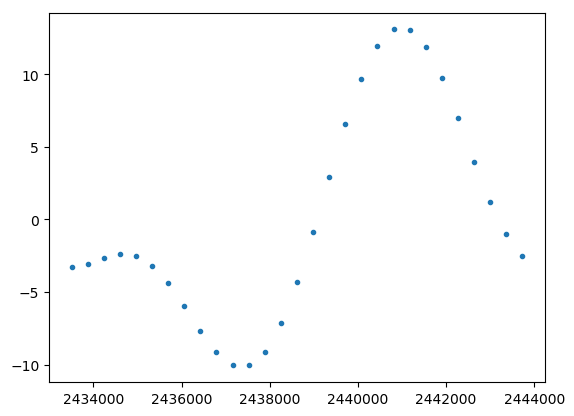

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13f5a05c0>

In [13]:
plot(time1,ttv1.*3600*24,".")

## Reference angle

In [ ]:
f = extract_data("OUTPUTS/moon_fitmtry2params.jld2")

In [ ]:
@load("mcmc_mtryresults.jld2")

In [ ]:
mu_1,P_1,t01,e1cosw1,e1sinw1,
mu_2,P_2,t02,e2cosw2,e2sinw2,
mu_3,P_3,t03,e3cosw3,e3sinw3,
tmaxsinphi0,tmaxcosphi0,deltaphi = f["pbest_global"]

In [ ]:
w1 = calc_deg(atan(e1sinw1,e1cosw1))
w2 = calc_deg(atan(e2sinw2,e2cosw2))
w3 = calc_deg(atan(e3sinw3,e3cosw3))
w1,w2,w3

In [ ]:
L_1 = calc_L(tt1,tt01,P_1,e1sinw1)
L_2 = calc_L(tt2,tt02,P_2,e2sinw2)
L_1,L_2

In [228]:
(((360/P1) .* (tt01 .- J2000)) .+ 181.97909950) 

49-element Array{Float64,1}:
 -27642.43014947823 
 -27282.430158204912
 -26922.43016693159 
 -26562.430175659018
 -26202.430184385696
 -25842.430193112374
 -25482.430201839055
 -25122.43021056648 
 -24762.43021929316 
 -24402.43022801984 
 -24042.43023674652 
 -23682.430245473945
 -23322.430254200626
      ⋮             
 -14322.430472371347
 -13962.430481098772
 -13602.430489825452
 -13242.430498552132
 -12882.430507278812
 -12522.430516006238
 -12162.430524732918
 -11802.430533459597
 -11442.430542186275
 -11082.430550913703
 -10722.430559640381
 -10362.430568367061

In [ ]:
((360/P_2) .* (tt02 .- J2000) .+ 100.46457166)

In [ ]:
[(360/P_3) .* (t03 .- J2000) .+ 34.39644051,
(360/P_3) .* (t03 .- J2000) .+ 34.39644051 + 360*1,
(360/P_3) .* (t03 .- J2000) .+ 34.39644051 + 360*2]

[Can't recall how i found this]

In [ ]:
77.56936298207381+w1,77.76976911511983+w2,77.91649744476126+w3

In [ ]:
xvalue = calc_deg.(atan.(vec(par_mcmc[:,iburn:nsteps,5]),vec(par_mcmc[:,iburn:nsteps,4]))) .+ 77.6
yvalue = calc_deg.(atan.(vec(par_mcmc[:,iburn:nsteps,10]),vec(par_mcmc[:,iburn:nsteps,9]))) .+ 77.8
optx = calc_deg(atan(e1sinw1,e1cosw1)) + 77.6
opty = calc_deg(atan(e2sinw2,e2cosw2)) + 77.8
truex = 131.601125535
truey = 102.78555318000001
meanx=mean(xvalue);sigmax=std(xvalue)
meany=mean(yvalue);sigmay=std(yvalue)
nbins=50
corner_plot(xvalue,yvalue,nbins,optx,opty,truex,truey)
xlabel(L"Longitude $\varpi$ of Venus [$deg$]")
ylabel(L"Longitude $\varpi$ of Earth [$deg$]")

In [ ]:
xvalue = calc_deg.(atan.(vec(par_mcmc[:,iburn:nsteps,15]),vec(par_mcmc[:,iburn:nsteps,14]))) .+ 77.9
yvalue = calc_deg.(atan.(vec(par_mcmc[:,iburn:nsteps,10]),vec(par_mcmc[:,iburn:nsteps,9]))) .+ 77.8
optx = calc_deg(atan(e3sinw3,e3cosw3)) + 77.9
opty = calc_deg(atan(e2sinw2,e2cosw2)) + 77.8
truex = 14.62221649
truey = 102.78555318000001
nbins=50
corner_plot(xvalue,yvalue,nbins,optx,opty,truex,truey)
xlabel(L"Longitude $\varpi$ of Jupiter [$deg$]")
ylabel(L"Longitude $\varpi$ of Earth [$deg$]")

In [ ]:
(360/P_3 * (t03 - J2000) - 34.39644051)

In [ ]:
corner_planet(vec(par_mcmc[:,iburn:nsteps,6]).* CGS.MSUN/CGS.MEARTH,
    vec(par_mcmc[:,iburn:nsteps,9]),
    vec(par_mcmc[:,iburn:nsteps,10]),
    vec(par_mcmc[:,iburn:nsteps,7]),
0.815,-0.004,-0.002,224.5)

In [ ]:
corner_planet(vec(par_mcmc[:,iburn:nsteps,11]).* CGS.MSUN/CGS.MEARTH,
    vec(par_mcmc[:,iburn:nsteps,14]),
    vec(par_mcmc[:,iburn:nsteps,15]),
    vec(par_mcmc[:,iburn:nsteps,12])
318,-0.004,-0.002,224.5)

## Testing